# Headers Required

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools as itert
from pyquil import Program
import pyquil.api as api
from pyquil.quil import DefGate
from pyquil.gates import *
from pyquil import get_qc
from pyquil.quilatom import unpack_qubit

# Defining our current function


#### This is a random function generator which gives a, b for current running instance.

#### This helps ensure that our test cases are not biased

In [2]:
def function_generator(n):
    # a- binary string of length n
    curr_index= np.random.randint(low=0,high=n,size=1)[0]
    a=[0]*n
    a[curr_index]=1
    #a = np.random.randint(low=0, high=2, size=n)
    print ("This is the (randomly chosen) value of a: ", a)
    # b- single bit binary digit
    #b = np.random.randint(low=0, high=2, size=1)
    #print ("This is the (randomly chosen) value of b: ", b)
    #return a,b
    return a

# Creating the Uf Matrix

#### The code differs from the Deutsch Jozsa algorithm only in terms of parameters and function application.
#### Using class to block user access to Uf and treat Uf as blackbox oracle 

In [3]:
class Uf: 
    #this function creates the blackbox oracle Uf matrix for a given function f that is parameterised for input size n
    #def __blackboxUf(self,n,a,b):
    def __blackboxUf(self,n,a):
        #this dictionary represents the correspondence between bit combinations and Uf indices
        indices_dict = {}
        counter = 0
        Uf = np.zeros((2**(n+1),2**(n+1)))
        
        bfx = 0

        # the for loops given below form the different pattern combinations that we need. The mapping between these combination and Uf matrix indices is stored in indices_dict
        for i in range(2**(n+1)):
        
            binary_form = ('{0:0'+str(n+1)+'b}').format(i) 
            indices_dict[binary_form] = counter
            counter += 1

        #print(indices_dict)
        #we then iterate through this pattern dictionary
        for key,val in indices_dict.items():
        
            #input to the function is the first n bits of the elements (bit patterns) from the dictionary
            x = key[0:n]
            #print("X= ", x)
            curr_dot_product = 0
            #for k, expand_q in enumerate(x):
                #print(x)
                #print(k)
                #curr_dot_product += a[k] * int(expand_q)
            for i in range(0,n):
                curr_dot_product += a[i] * int(x[i])
            curr_dot_product %= 2
            #curr_dot_product= int(curr_dot_product) + int(b)
            #curr_dot_product %= 2
        
            # f from current string
        
            fx= str(curr_dot_product) 
        
            #fx represents the output of function f given the input x
            #fx = str(f(x))
        
            #b1 is the last bit of the bit pattern in the dictionary item
            b1 = key[n]
        
            #below we have the (f(x) + b) mod 2
            if(b1==fx):
                bfx = '0'
            else:
                bfx = '1'
                # print(bfx)
        
            #the final bit string is the concatenation of the input x and bfx
            target = x + bfx
            # print('t',target)
        
            #using indices_dict we can now find the index that corresponds to this output
            target_index = indices_dict[target]
            # print(val,target_index)
        
            #now using the target indiex we can create a bit pattern with all 0s and 1 at the target index position
            Uf[val][target_index] = 1
        
        return Uf
    #def createUf(self,n,a,b):
    def createUf(self,n,a):
        #return self.__blackboxUf(n,a,b)
        return self.__blackboxUf(n,a)

# Create Z_0

In [4]:
def createz0 (n):
    matrix_z= np.eye(2**(n+1))
    matrix_z[0][0]=-1
    matrix_z=(-1)*matrix_z
    return matrix_z



# Creating our main circuit

* This circuit will be used to find 'a'. [Displayed in Results]

* Implementation similar to Deutsch Jozsa except in terms of params and some function calls.

* After measurement, the last bit can be discarded as its the result from the helper bit. All other bits denote 'a'

* for n=1, circuit should look like

###### |0> - H - | Uf |- H - M -
###### |1> - H - |___|- x




In [5]:
#def runMainCircuit(function,n,nTrials):
def runMainCircuit():
    
    
    # Taking the input n from the user
    n= int(input("Enter length of function input [Don't include helper bit in n and ONLY Integer Values Allowed]: "))
    
    # number of iterations
    num_of_iterations = max(1, int(np.sqrt(2**(n-2))))
    
    # creating an instance of Uf
    
    uf = Uf()
    # generating my function
    print ("\n\n-----------This function is not accessible to user-----------")
    print ("Function generator output shown for verification/ proof of correctness ")
    
    #curr_a, curr_b = function_generator(n)
    curr_a=function_generator(n)
    print ("-----------Restricted section over-----------\n\n")
    
    
    
    
    
    # adding Uf gate
    
    # creating our Uf matrix 
    
    
    UfMatrix = uf.createUf(n,curr_a) 
    GateName = "UF_GATE_GROVER"
    print("Uf Matrix obtained: \n", UfMatrix)
    
    matrix_z0= createz0(n)
    Gate0="minus_Z0"
    
    
    
    
    # one extra bit as our helper bit 
    n = n+1
    
    #defining a gate using its name and matrix
    uf_gate_definition = DefGate(GateName, UfMatrix)
    qubits = [unpack_qubit(i) for i in range(0,n)]
    z0_gate = DefGate(Gate0,matrix_z0)
    
    
    # defining start of PyQuil program
    p = Program()
    
    qc_name = "{}q-qvm".format(n)
    
    # Get our QuantumComputer instance, with a Quantum Virutal Machine (QVM) backend
    
    qc = get_qc(qc_name)
    qc.compiler.client.timeout = 600 # number of seconds
    
    
    
    # Time taken by program needs to be checked.
    start = time. time()    
    
    # setting last qubit to 1
    #p += X(n-1)
    
    # adding Hadamard gates to all qubits
    for i in range(0,n-1):
        p += H(i)
        
    #p+=Program(uf_gate_definition,Gate(name=GateName, params=[],qubits=qubits))
    
    for _ in range(num_of_iterations):
        p += H(n-1)
        p+=Program(uf_gate_definition,Gate(name=GateName, params=[],qubits=qubits))
        p += H(n-1)
        for i in range(0,n-1):
                p += H(i)
        p += H(n-1)
        p+=Program(z0_gate,Gate(name=Gate0, params=[],qubits=qubits))
        p += H(n-1)
        for i in range(0,n-1):
                p += H(i)
        
        # apply oracle
        
        #p.inst(("U_bb",) + tuple(range(n+1)[::-1]))
        # apply H . U_perp . H
        #p.inst(("U_grov",) + tuple(range(1, n+1)[::-1]))
    
    
    
    # helper bit does not require H gate. Result is treated as trash/ garbage
    
    #for i in range(0,n-1):
        #p += H(i)
        
    # transformed matrix
    
    #print("p at this point:")
    
    #print(p)
    # measurement result    
    results = qc.run_and_measure(p, trials=1)    
    print("Results: ")
    print(results)
    qvm = api.QVMConnection()
    wavefunc = qvm.wavefunction(p)
    outcome_probs = wavefunc.get_outcome_probs()
    print ("The most probable outcome is: |%s>" % (max(outcome_probs, key=outcome_probs.get)[:-1]))
    # histogram of outcome probs
    plt.figure(figsize=(8, 6))
    plt.bar([i[:-1] for i in outcome_probs.keys()], outcome_probs.values())
    plt.show()
    end = time. time()
    
    print("Time taken by program: ", end-start)

# Grovers - Test Case Examples

## Trial 1: n =1

Enter length of function input [Don't include helper bit in n and ONLY Integer Values Allowed]: 1


-----------This function is not accessible to user-----------
Function generator output shown for verification/ proof of correctness 
This is the (randomly chosen) value of a:  [1]
-----------Restricted section over-----------


Uf Matrix obtained: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
Results: 
{0: array([0]), 1: array([1])}
The most probable outcome is: |1>


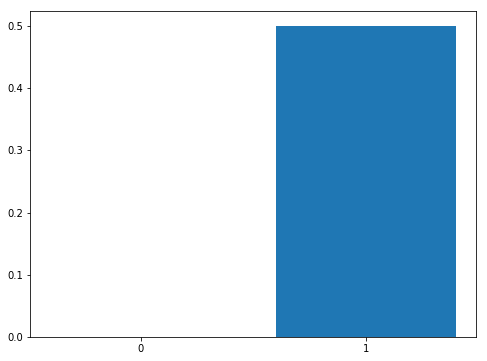

Time taken by program:  1.016512155532837


In [6]:
runMainCircuit()

## Trial 2: n=2

Enter length of function input [Don't include helper bit in n and ONLY Integer Values Allowed]: 2


-----------This function is not accessible to user-----------
Function generator output shown for verification/ proof of correctness 
This is the (randomly chosen) value of a:  [1, 0]
-----------Restricted section over-----------


Uf Matrix obtained: 
 [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]
Results: 
{0: array([0]), 1: array([0]), 2: array([1])}
The most probable outcome is: |10>


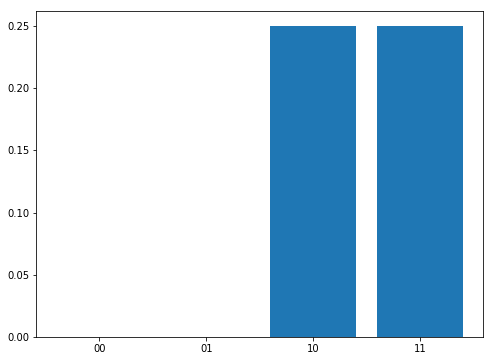

Time taken by program:  1.7829465866088867


In [7]:
runMainCircuit()

## Trial 3: n=3

Enter length of function input [Don't include helper bit in n and ONLY Integer Values Allowed]: 3


-----------This function is not accessible to user-----------
Function generator output shown for verification/ proof of correctness 
This is the (randomly chosen) value of a:  [1, 0, 0]
-----------Restricted section over-----------


Uf Matrix obtained: 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

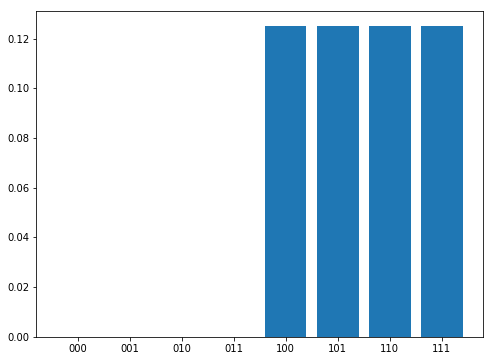

Time taken by program:  4.7907328605651855


In [8]:
runMainCircuit()